# EPPE is short for 'EnergyPLAN Power Flow'
## It attempts to perform power flow optimization based on outputs from EnergyPLAN.
## It leans heavily on some packages, namely gurobi, networkx, pandas.

In [1]:
from __future__ import print_function, division
import os
import pandas as pd
import numpy as np
import gurobipy as gb
import timeit
import networkx as nx
from vresutils import timer
from multiprocessing import Pool
import matplotlib.pyplot as plt
%matplotlib inline

## The following function drops superfluous data points, to avoid warning from Gurobi

In [2]:
def drop_duplicates_from_index(self,keep='first',inplace=False):
    """Return self with duplicate indices removed
    Parameters
    ----------
    keep : {'first_last', first', 'last', False}, default 'first'
        - ``first_last`` : Drop duplicates except for the first and the last occurence
        - otherwise default 'drop_duplicates' behaviour.
    """
    if keep=='first_last':
        result = self[np.logical_not(self.index.duplicated(keep='first')) | np.logical_not(self.index.duplicated(keep='last'))]
    else:
        result = self[np.logical_not(self.index.duplicated(keep=keep))]
    if inplace:
        return self._update_inplace(result)
    else:
        return result
pd.Series.drop_duplicates_from_index = drop_duplicates_from_index

## Load data, calculate incidence matrix and PTDF matrix

In [3]:
# load graph data
nodes = pd.read_csv("data/graph/nodes14.csv",header=None,squeeze=True).values
edges = pd.read_csv("data/graph/edges.csv",header=None).values

index = []
for n, edge in enumerate(edges):
    if edge[0] in nodes and edge[1] in nodes:
        index.append(True)
    else:
        index.append(False)
edges = edges[index]
network = nx.Graph()
network.add_nodes_from(nodes)
network.add_edges_from(edges)
nodes = network.nodes()
edges = network.edges()

In [4]:
# sus = pd.Series()
# for edge in edges:
#     l = edge[0]+'-'+edge[1]
#     sus[l]=1
# sus.to_csv('./data/graph/susceptance14.csv')
fl_b = pd.read_csv('./data/graph/flow_constraints_14.csv',header=0,index_col=0)
Fl_b = []
for n, edge in enumerate(edges):
    try:
        l = edge[0]+'-'+edge[1]
        Fl_b.append(fl_b.loc[l,'BC'])
    except KeyError:
        l = edge[1]+'-'+edge[0]
        Fl_b.append(fl_b.loc[l,'BC'])

In [5]:
# assume link susceptances are equal
link_susceptances = np.ones(len(network.edges()))

# the dimension of incidence matrix is n*l
K = (-nx.incidence_matrix(network,oriented=True)).toarray()
O = np.diag(link_susceptances)
B_inverse = np.linalg.pinv((K.dot(O)).dot(K.T))

# H = O*K^T*B^-1, H is used for simplified AC power flow
H = (O.dot(K.T)).dot(B_inverse)
H[abs(H)<1e-13]=0

# load Cost-Balancing data from EnergyPLAN
CB = {}
for n in nodes:
#     df = pd.read_csv("data/cost_blancing/{}.csv".format(n),index_col=0,sep=',')
    df = pd.read_csv("data/Scenarios/{}15.csv".format(n),index_col=0,sep=';')
    df.columns = pd.to_numeric(df.columns.values)
    # convert from MWh to GWh
    CB[n] = df/1e3

epsilon = 1e-2
inf = gb.GRB.INFINITY

## Perform the flow optimization for each time step independently, and store the result in a pandas dataframe

In [6]:
# function EPPF receives a time step, perform the power flow optimization, 
# then return the result in a pandas Series, named by the time step (t-1)
def EPPF(t):
    # initialize the gurobi model
    m = gb.Model()
    m.setParam('OutputFlag', 0)
    m.Params.Threads=1 

    # create the variable called total flow, positive indicates export and negative corresponds to import
    fl_t = [m.addVar(lb=-Fl_b[n],ub=Fl_b[n],name='link {}-{}'.format(edge[0],edge[1])) for n,edge in enumerate(edges)]
#     fl_t = [m.addVar(lb=-inf,ub=inf,name='link {}-{}'.format(edge[0],edge[1])) for n,edge in enumerate(edges)]
    
    Obj = gb.QuadExpr()
    Obj.addTerms(np.repeat(epsilon,len(edges)),fl_t,fl_t)

    # add fl_t^2 to the objective function, weighted by epsilon
    m.setObjective(expr=Obj)

    b = {}
    p = {}
    lbs =[]
    for n in nodes:
        b[n] = CB[n].loc[t,:].values.tolist()
        lbs.append(b[n][0])
        a = pd.Series(index=b[n],data = CB[n].columns.values.tolist())
        a = a.drop_duplicates_from_index(keep='first_last')
        a.sort_index(inplace=True)
        b[n] = a.index.values
        p[n] = a.values

    # add two more variables, namely injection and curtailment
    P = [m.addVar(lb=-inf, name='P {}'.format(node)) for node in nodes]
    C = [m.addVar(lb=0., name='C {}'.format(node)) for node in nodes]
    # create the variable called Response
    R = [m.addVar(lb=lb, name='R {}'.format(node)) for node,lb in zip(nodes,lbs)]
    m.update()
    
    # add piecewise linear objective function, 
    [m.setPWLObj(R[nn],b[node],p[node]*(b[node]-b[node][0])) for nn,node in enumerate(nodes)]
    
#     # R>=P
#     [m.addConstr(R[nn]-gb.LinExpr(K[nn],fl_t) >= 0) for nn in range(len(nodes))]
    
    [m.addConstr(R[nn]-P[nn]-C[nn] == 0) for nn in range(len(nodes))]
    [m.addConstr(P[nn]-gb.LinExpr(K[nn],fl_t) == 0) for nn in range(len(nodes))]
    
#     for nn,node in enumerate(nodes):
#         m.addConstr(P[nn] - (
#             gb.quicksum([fl_t[ll] for ll,edge in enumerate(edges) if edge[0]==node]) +
#             gb.quicksum([-fl_t[ll] for ll,edge in enumerate(edges) if edge[1]==node])
#             ) == 0 ,'balance-{}'.format(node))

    m.optimize()

    # store the result into a dataframe
    d = {}
    for v in m.getVars():
        d[v.VarName] = v.X
    d['Objective'] = m.ObjVal
    return pd.Series(d,name=t-1)

In [7]:
%%time
cores = 2
p = Pool(cores)
T = 24*366
r = p.map(EPPF,range(1,T+1))
results = pd.DataFrame()
for i in range(T):
    results = pd.concat([results,r[i]],axis=1)
results = results.T

CPU times: user 18.5 s, sys: 4.8 s, total: 23.3 s
Wall time: 1min 9s


In [8]:
results.to_csv('results.csv')

In [9]:
# store the result seperately in 
# C(curtailment), P(injection), R(response), L(links), O(objective value)
index = []
for col in results.columns:
    if 'C ' in col:
        index.append(True)
    else:
        index.append(False)
C = results.loc[:,index]

index = []
for col in results.columns:
    if 'P ' in col:
        index.append(True)
    else:
        index.append(False)
P = results.loc[:,index]

index = []
for col in results.columns:
    if 'R ' in col:
        index.append(True)
    else:
        index.append(False)
R = results.loc[:,index]

index = []
for col in results.columns:
    if 'link ' in col:
        index.append(True)
    else:
        index.append(False)
L = results.loc[:,index]

O = results.loc[:,'Objective']

In [10]:
abs(L).max().sum()

38.768999999999934

In [11]:
O.mean()

8348.006952705146

## Make plots

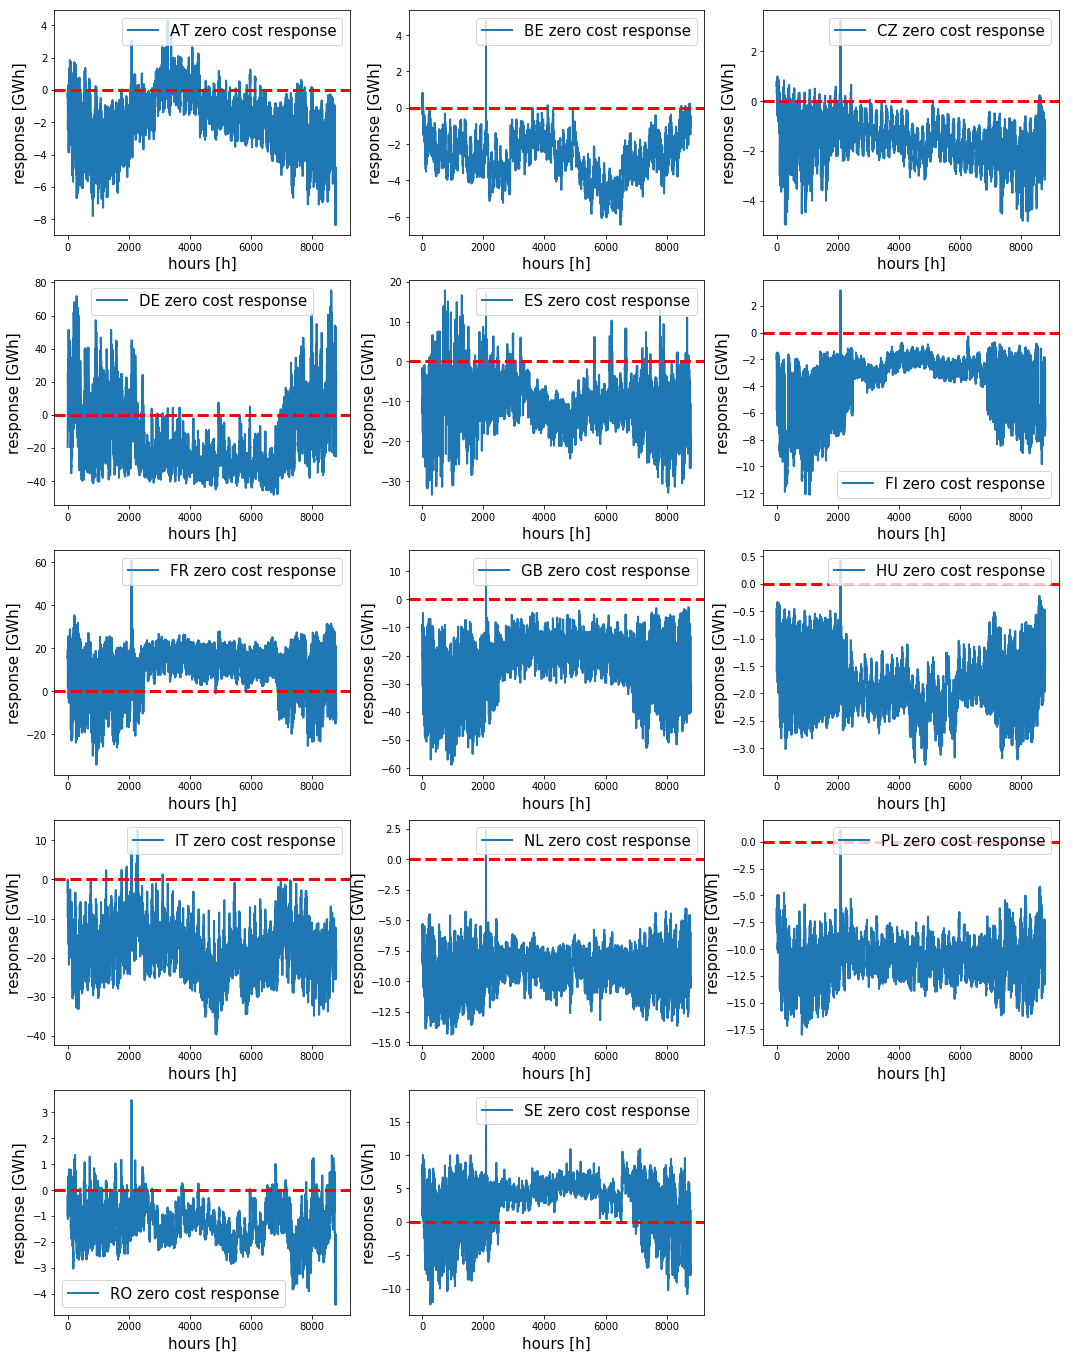

In [12]:
# the response value at zero cost for each country
n_row = 5
n_col = 3

fonts = 15
tick = 15
linewidth = 2
fig,axes = plt.subplots(n_row,n_col)
fig.set_size_inches(18,24)
axes[-1,-1].axis('off')
for n, country in enumerate(nodes):
    row = int(n/n_col)
    col = n % n_col
    CB[country].loc[:,0].plot(linewidth=linewidth,ax=axes[row,col])
    axes[row,col].axhline(linestyle='--',linewidth=3,color='r')
    axes[row,col].legend(['{} zero cost response'.format(country)],fontsize=fonts)
    axes[row,col].set_xlabel('hours [h]',fontsize=fonts)
    axes[row,col].set_ylabel('response [GWh]',fontsize=fonts)
# fig.savefig('./231117_CHP_workshop_slides/figures/RIC_{}_2.pdf'.format(country),dpi=500)

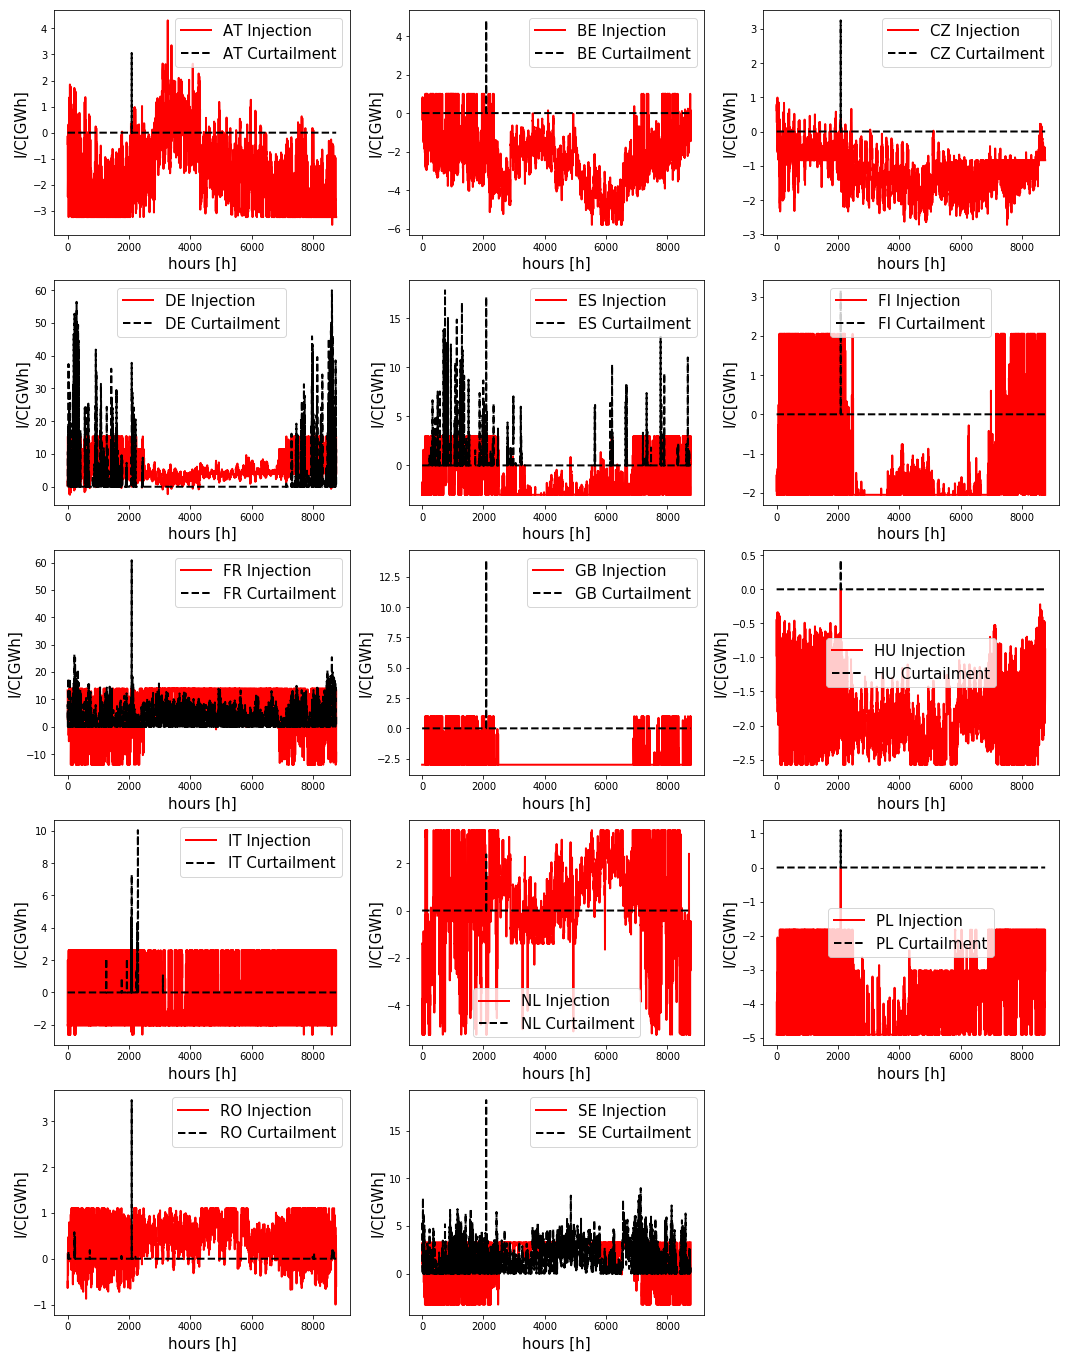

In [13]:
# injection and curtailment patterns for the whole year
t_min = 24*0
t_max = 24*365
n_row = 5
n_col = 3

fonts = 15
tick = 15
linewidth = 2
fig,axes = plt.subplots(n_row,n_col)
fig.set_size_inches(18,24)
axes[-1,-1].axis('off')
for n, country in enumerate(nodes):
    row = int(n/n_col)
    col = n % n_col
    results.loc[t_min:t_max,'P '+country].plot(linewidth=linewidth,ax=axes[row,col],color='r')
    results.loc[t_min:t_max,'C '+country].plot(linewidth=linewidth,ax=axes[row,col],color='k',style='--')
    # results.loc[t_min:t_max,'R '+country].plot(linewidth=linewidth*2,ax=ax,color='b',style='--')
    axes[row,col].legend(['{} Injection'.format(country),'{} Curtailment'.format(country),'{} Response'.format(country)],fontsize=fonts)
    axes[row,col].set_xlabel('hours [h]',fontsize=fonts)
    axes[row,col].set_ylabel('I/C[GWh]',fontsize=fonts)
# fig.savefig('./231117_CHP_workshop_slides/figures/RIC_{}_2.pdf'.format(country),dpi=500)

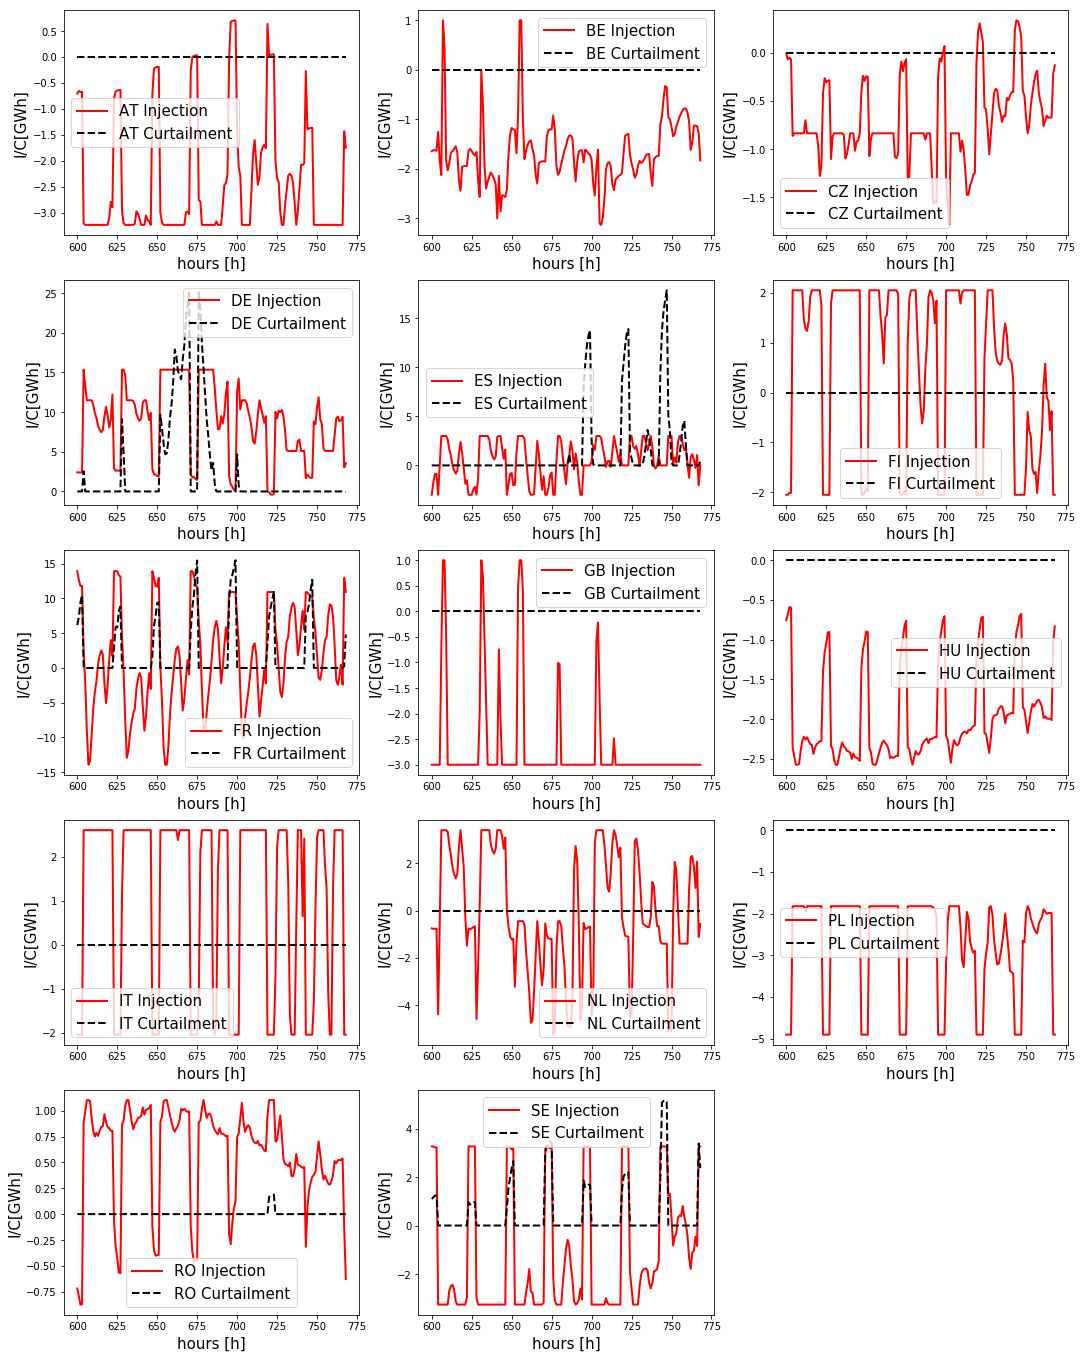

In [14]:
# injection and curtailment patterns for a winter week
t_min = 24*25
t_max = 24*32
n_row = 5
n_col = 3

fonts = 15
tick = 15
linewidth = 2
fig,axes = plt.subplots(n_row,n_col)
fig.set_size_inches(18,24)
axes[-1,-1].axis('off')
for n, country in enumerate(nodes):
    row = int(n/n_col)
    col = n % n_col
    results.loc[t_min:t_max,'P '+country].plot(linewidth=linewidth,ax=axes[row,col],color='r')
    results.loc[t_min:t_max,'C '+country].plot(linewidth=linewidth,ax=axes[row,col],color='k',style='--')
    # results.loc[t_min:t_max,'R '+country].plot(linewidth=linewidth*2,ax=ax,color='b',style='--')
    axes[row,col].legend(['{} Injection'.format(country),'{} Curtailment'.format(country),'{} Response'.format(country)],fontsize=fonts)
    axes[row,col].set_xlabel('hours [h]',fontsize=fonts)
    axes[row,col].set_ylabel('I/C[GWh]',fontsize=fonts)
# fig.savefig('./231117_CHP_workshop_slides/figures/RIC_{}_2.pdf'.format(country),dpi=500)

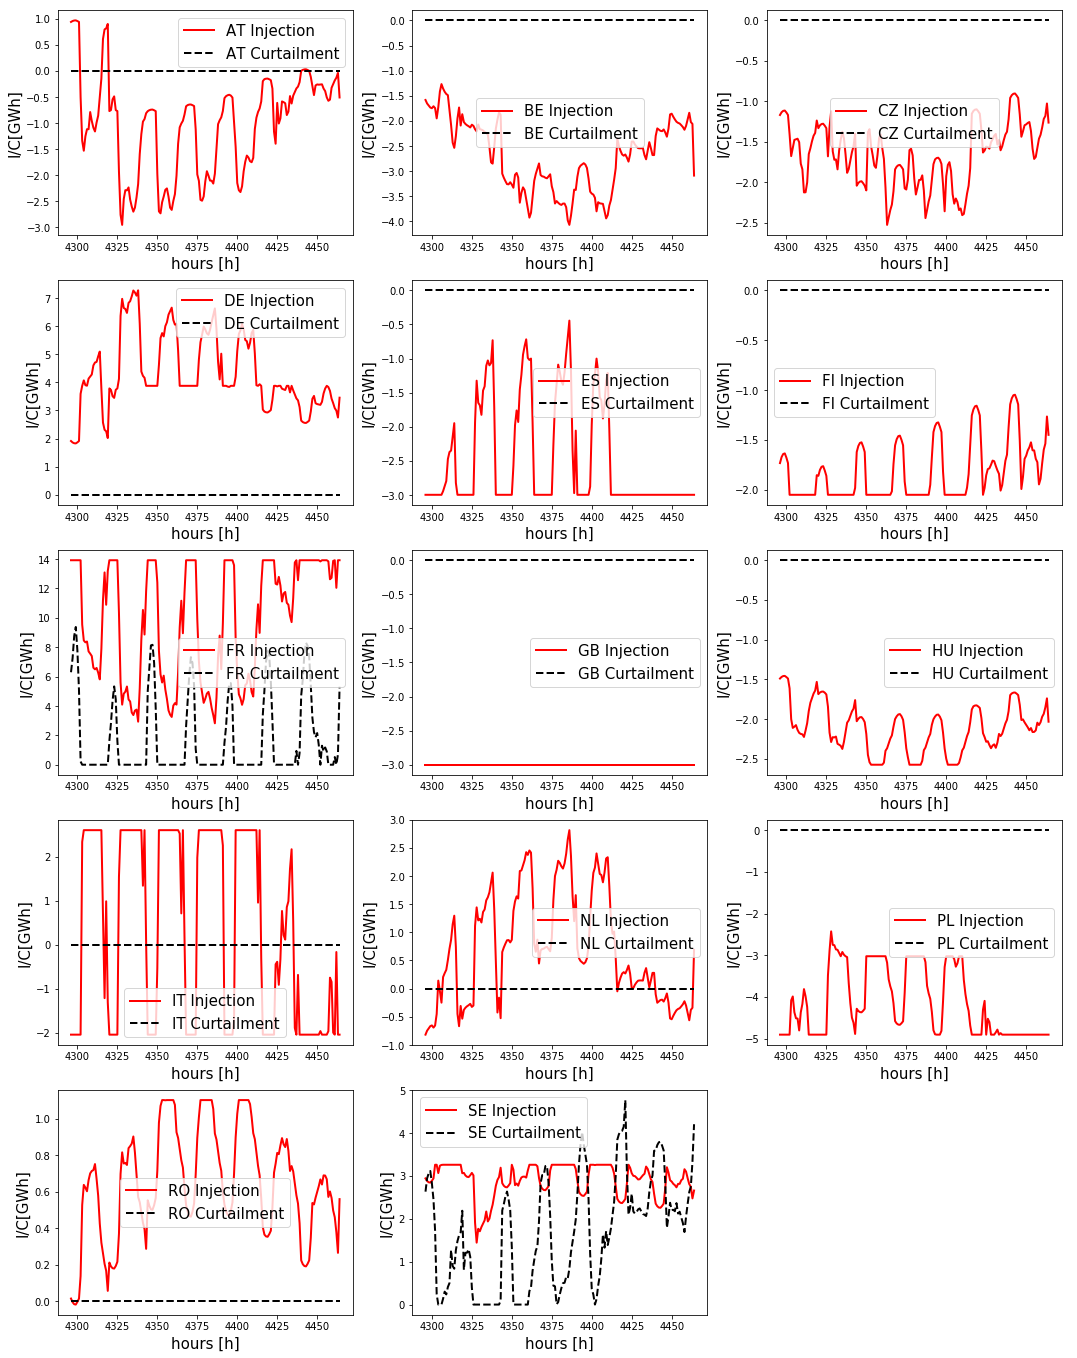

In [15]:
# injection and curtailment patterns for a summer week
t_min = 24*179
t_max = 24*186
n_row = 5
n_col = 3

fonts = 15
tick = 15
linewidth = 2
fig,axes = plt.subplots(n_row,n_col)
fig.set_size_inches(18,24)
axes[-1,-1].axis('off')
for n, country in enumerate(nodes):
    row = int(n/n_col)
    col = n % n_col
    results.loc[t_min:t_max,'P '+country].plot(linewidth=linewidth,ax=axes[row,col],color='r')
    results.loc[t_min:t_max,'C '+country].plot(linewidth=linewidth,ax=axes[row,col],color='k',style='--')
    # results.loc[t_min:t_max,'R '+country].plot(linewidth=linewidth*2,ax=ax,color='b',style='--')
    axes[row,col].legend(['{} Injection'.format(country),'{} Curtailment'.format(country),'{} Response'.format(country)],fontsize=fonts)
    axes[row,col].set_xlabel('hours [h]',fontsize=fonts)
    axes[row,col].set_ylabel('I/C[GWh]',fontsize=fonts)
# fig.savefig('./231117_CHP_workshop_slides/figures/RIC_{}_2.pdf'.format(country),dpi=500)

In [16]:
# country = 'FR'
# t_min = 24*173
# t_max = 24*186

# fonts = 40
# tick = 40
# linewidth = 4
# fig,ax = plt.subplots()
# fig.set_size_inches(18,12)
# results.loc[t_min:t_max,'P '+country].plot(linewidth=linewidth,ax=ax,color='r')
# results.loc[t_min:t_max,'C '+country].plot(linewidth=linewidth,ax=ax,color='k',style='--')
# # results.loc[t_min:t_max,'R '+country].plot(linewidth=linewidth*2,ax=ax,color='b')
# plt.legend(['Injection','Curtailment','Response'],fontsize=fonts*0.9)
# plt.xlabel('hours [h]',fontsize=fonts)
# plt.ylabel('I/C[GWh]',fontsize=fonts)
# plt.xticks(fontsize=tick)
# plt.yticks(fontsize=tick)

(array([-40., -30., -20., -10.,   0.,  10.,  20.,  30.]),
 <a list of 8 Text yticklabel objects>)

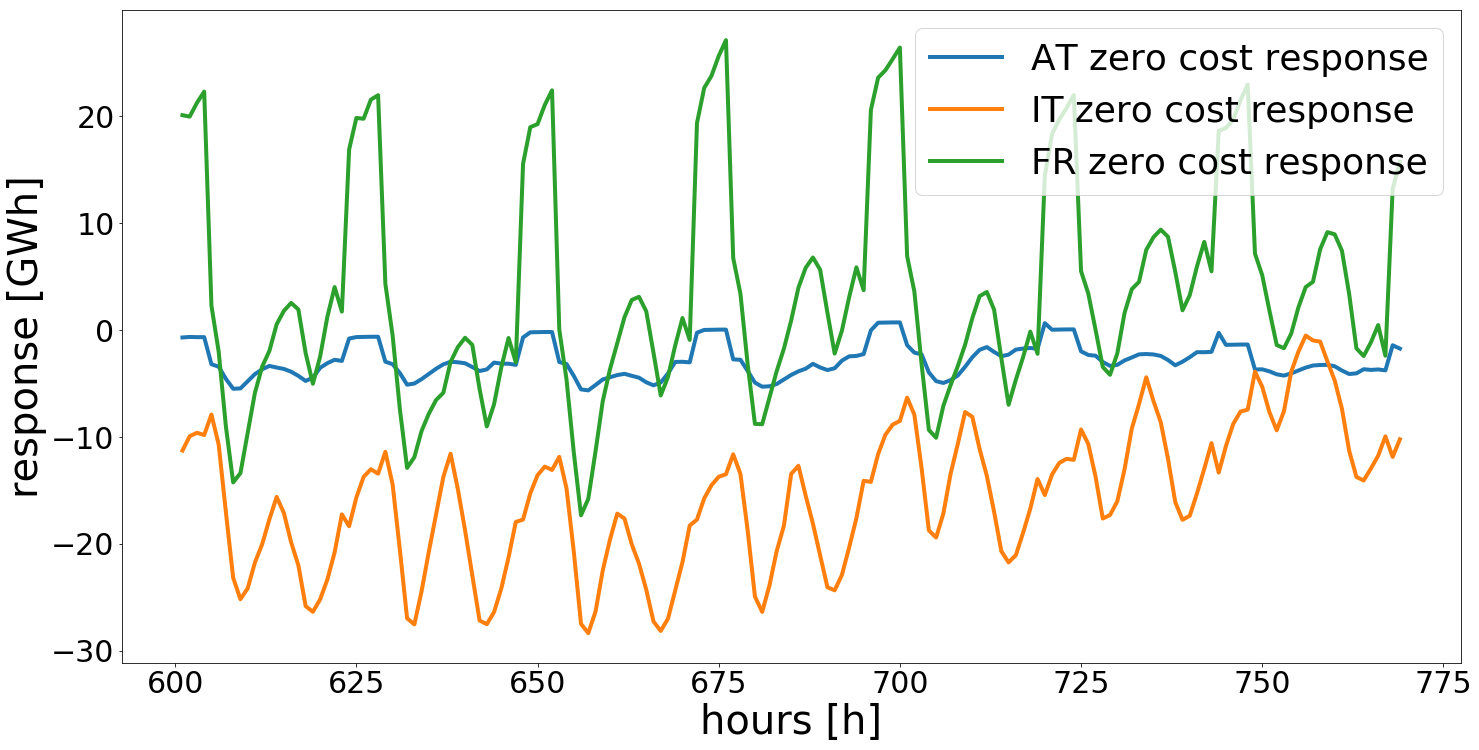

In [17]:
# compare one country's the zero cost response value to its neighbouring countries'
country = 'IT'
t_min = 24*25
t_max = 24*32
links = [edge for edge in edges if country in edge]
countries = []
for l in links:
    if l[0] not in countries:
        countries.append(l[0])
    if l[1] not in countries:
        countries.append(l[1])    

fonts=40
tick=30
linewidth=4
fig,ax = plt.subplots()
fig.set_size_inches(24,12)
legend = []
for c in countries:
    CB[c].loc[t_min+1:t_max+1,0].plot(linewidth=linewidth, ax=ax)
    legend.append('{} zero cost response'.format(c))
plt.legend(legend,fontsize=fonts*0.9)
plt.xlabel('hours [h]',fontsize=fonts)
plt.ylabel('response [GWh]',fontsize=fonts)
plt.xticks(fontsize=tick)
plt.yticks(fontsize=tick)
# fig.savefig('./231117_CHP_workshop_slides/figures/Links_{}.pdf'.format(country),dpi=500)

(array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.]),
 <a list of 9 Text yticklabel objects>)

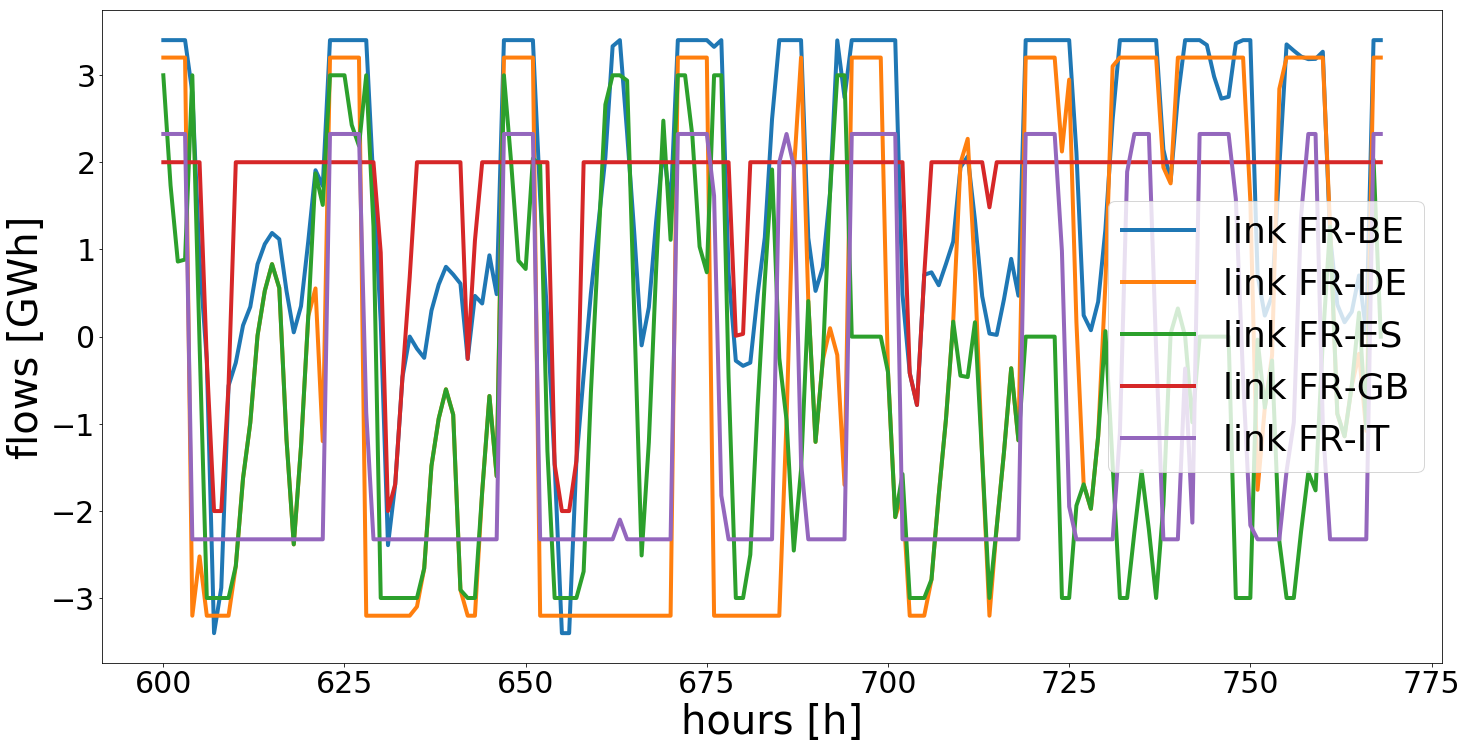

In [18]:
# the power flow pattern of one country in a winter week
country = 'FR'
t_min = 24*25
t_max = 24*32
links = [edge for edge in edges if country in edge]

fonts=40
tick=30
linewidth=4
fig,ax = plt.subplots()
fig.set_size_inches(24,12)
legend = []
for link in links:
    if link[0]==country:
        (results.loc[t_min:t_max,'link '+link[0]+'-'+link[1]]).plot(linewidth=linewidth,ax=ax)
        legend.append('link '+link[0]+'-'+link[1])
    else:
        (-results.loc[t_min:t_max,'link '+link[0]+'-'+link[1]]).plot(linewidth=linewidth,ax=ax)
        legend.append('link '+link[1]+'-'+link[0])
plt.legend(legend,fontsize=fonts*0.9)
plt.xlabel('hours [h]',fontsize=fonts)
plt.ylabel('flows [GWh]',fontsize=fonts)
plt.xticks(fontsize=tick)
plt.yticks(fontsize=tick)
# fig.savefig('./231117_CHP_workshop_slides/figures/Links_{}.pdf'.format(country),dpi=500)

(array([-3., -2., -1.,  0.,  1.,  2.,  3.,  4.]),
 <a list of 8 Text yticklabel objects>)

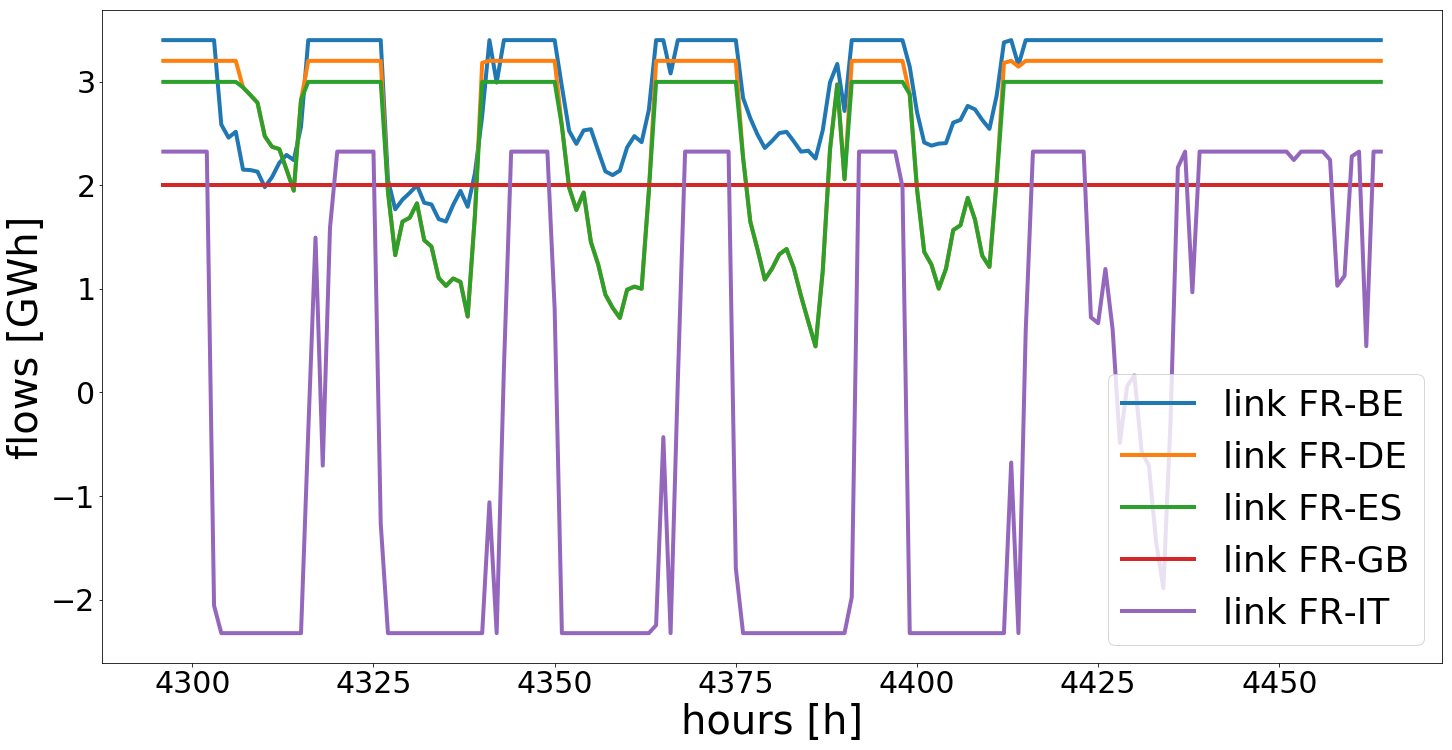

In [19]:
# the power flow pattern of one country in a summer week
country = 'FR'
t_min = 24*179
t_max = 24*186
links = [edge for edge in edges if country in edge]

fonts=40
tick=30
linewidth=4
fig,ax = plt.subplots()
fig.set_size_inches(24,12)
legend = []
for link in links:
    if link[0]==country:
        (results.loc[t_min:t_max,'link '+link[0]+'-'+link[1]]).plot(linewidth=linewidth,ax=ax)
        legend.append('link '+link[0]+'-'+link[1])
    else:
        (-results.loc[t_min:t_max,'link '+link[0]+'-'+link[1]]).plot(linewidth=linewidth,ax=ax)
        legend.append('link '+link[1]+'-'+link[0])
plt.legend(legend,fontsize=fonts*0.9)
plt.xlabel('hours [h]',fontsize=fonts)
plt.ylabel('flows [GWh]',fontsize=fonts)
plt.xticks(fontsize=tick)
plt.yticks(fontsize=tick)
# fig.savefig('./231117_CHP_workshop_slides/figures/Links_{}.pdf'.format(country),dpi=500)